<a href="https://colab.research.google.com/github/mgarbanzo/AgrometeoUCR/blob/main/Agrometeorolog%C3%ADa_UCR_2021_NDVI_Boto3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pip
!pip install netcdf4
!pip uninstall -y shapely imgaug
!pip install cartopy
!pip install shapely --no-binary shapely --force
!pip install boto3

     |████████████████████████████████| 1.6MB 5.0MB/s 
  Found existing installation: pip 19.3.1
    Uninstalling pip-19.3.1:
      Successfully uninstalled pip-19.3.1
Found existing installation: Shapely 1.7.1
Uninstalling Shapely-1.7.1:
  Successfully uninstalled Shapely-1.7.1
Found existing installation: imgaug 0.2.9
Uninstalling imgaug-0.2.9:
  Successfully uninstalled imgaug-0.2.9
     |████████████████████████████████| 12.1 MB 5.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.0 MB 52.0 MB/s 
     |████████████████████████████████| 219 kB 62.7 MB/s 
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12516211 sha256=71c9c659399d9fb9b3eae5f5d8815b652eeb490f3102ea5a7a4114d6a23463e6
  Stored in directory: /root/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
  Created wheel for pyshp: file

In [2]:
def download_file(s3_client, prefix):
    # Seach for the file on the server
    s3_result = s3_client.list_objects_v2(Bucket=bucket_name, Prefix=prefix, Delimiter = "/")
    # Check if there are files available
    if 'Contents' not in s3_result:
        # There are no files
        print("No files found for the date: ",year,day_of_year)
        quit()
    else:
        # There are files
        for obj in s3_result['Contents']:
            # Print the file name
            key = obj['Key']
            print(key)
            file_name = key.split('/')[-1].split('.')[0]
      
            # Download the file
            if not os.path.exists(f'{input}/{file_name}.nc'):
                s3_client.download_file(bucket_name, key, f'{input}/{file_name}.nc')

    return file_name

In [3]:
from netCDF4 import Dataset          # Read / Write NetCDF4 files
import matplotlib.pyplot as plt      # Plotting library
from datetime import datetime        # Basic Dates and time types
import cartopy, cartopy.crs as ccrs  # Plot maps
import os                            # Miscellaneous operating system interfaces
import boto3                         # Amazon Web Services (AWS) SDK for Python
from botocore import UNSIGNED        # boto3 config
from botocore.config import Config   # boto3 config

ABI-L2-CMIPF/2021/037/18/OR_ABI-L2-CMIPF-M6C02_G16_s20210371800122_e20210371809430_c20210371809511.nc
ABI-L2-CMIPF/2021/037/18/OR_ABI-L2-CMIPF-M6C03_G16_s20210371800122_e20210371809430_c20210371809509.nc


/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/usr/local/lib/python3.7/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


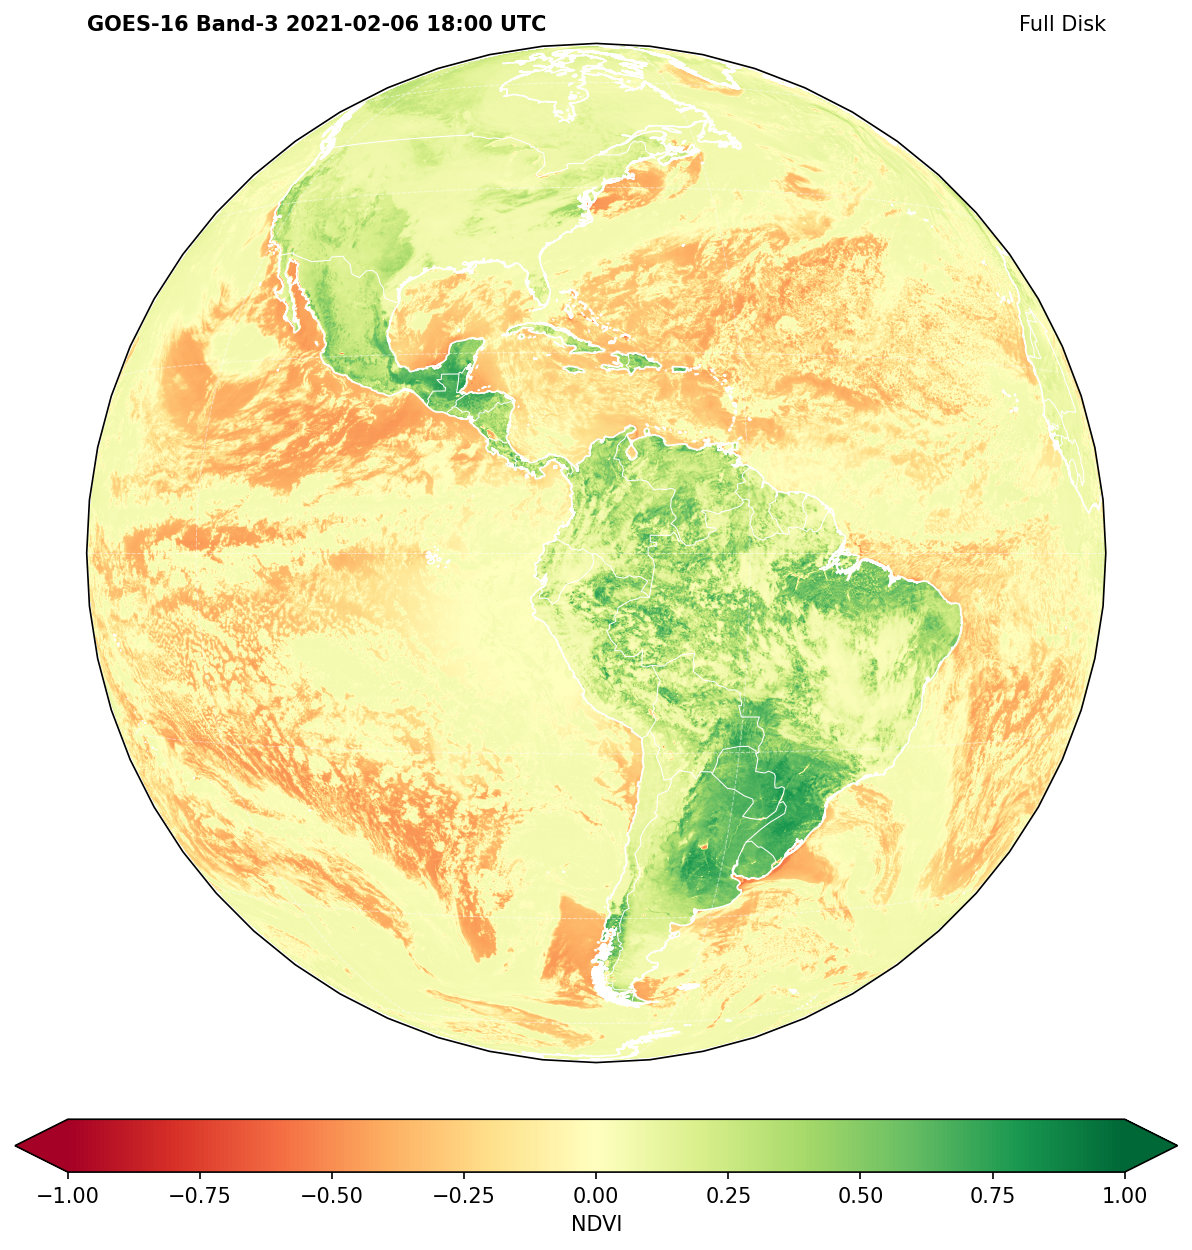

In [4]:
# Input and output directories
input = "/content/Samples"; os.makedirs(input, exist_ok=True)
output = "/content/Output"; os.makedirs(output, exist_ok=True)

# AMAZON repository information 
# https://noaa-goes16.s3.amazonaws.com/index.html
bucket_name = 'noaa-goes16'
product_name = 'ABI-L2-CMIPF'

year = 2021
day_of_year = 37
hour = 18
min = 00

#CANAL 2
band = 2
# Initializes the S3 client
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
#-----------------------------------------------------------------------------------------------------------
# File structure
prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M6C{band:02.0f}_G16_s{year}{day_of_year:03.0f}{hour:02.0f}{min:02.0f}'

# Download the file
file_name = download_file(s3_client, prefix)
#-----------------------------------------------------------------------------------------------------------
# Open the GOES-R image
file = Dataset(f'{input}/{file_name}.nc')        

# Get the pixel values
dataCH02 = file.variables['CMI'][::2,::2]
#-----------------------------------------------------------------------------------------------------------

#CANAL 3
band = 3
# Initializes the S3 client
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
#-----------------------------------------------------------------------------------------------------------
# File structure
prefix = f'{product_name}/{year}/{day_of_year:03.0f}/{hour:02.0f}/OR_{product_name}-M6C{band:02.0f}_G16_s{year}{day_of_year:03.0f}{hour:02.0f}{min:02.0f}'

# Download the file
file_name = download_file(s3_client, prefix)
#-----------------------------------------------------------------------------------------------------------
# Open the GOES-R image
file = Dataset(f'{input}/{file_name}.nc')        

# Get the pixel values
dataCH03 = file.variables['CMI'][:]
#-----------------------------------------------------------------------------------------------------------

NDVI = (dataCH03 - dataCH02)/(dataCH03 + dataCH02)

# Choose the plot size (width x height, in inches)
plt.figure(figsize=(10,10), dpi=150)

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))
img_extent = (-5434894.67527,5434894.67527,-5434894.67527,5434894.67527)

# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='white', linewidth=0.8)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='white', linewidth=0.5)
ax.gridlines(color='white', alpha=0.5, linestyle='--', linewidth=0.5)

colormap = "RdYlGn"
prodname = "NDVI"

# Plot the image
img = ax.imshow(NDVI, origin='upper', extent=img_extent, cmap=colormap)

# Add a colorbar
plt.colorbar(img, label=prodname, extend='both', orientation='horizontal', pad=0.05, fraction=0.05)

# Extract date
date = (datetime.strptime(file.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 Band-' + str(band) + ' ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=10, loc='left')
plt.title('Full Disk', fontsize=10, loc='right')
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/NDVI.png')

# Show the image
plt.show()